In [2]:
import pandas as pd
import glob
import os

# ─────── Load all concise rewrite files ───────
file_paths = [
    "concise_rewrites_10.csv",
    "concise_rewrites_20.csv",
    "concise_rewrites_30.csv",
    "concise_rewrites_40.csv",
    "concise_rewrites_50.csv",
    "concise_rewrites_60.csv",
    "concise_rewrites_70.csv",
    "concise_rewrites_80.csv",
    "concise_rewrites_90.csv",
]

dfs = []
for file in file_paths:
    if os.path.exists(file):
        df = pd.read_csv(file)
        
        # Extract percentage from filename (e.g. "20", "40", etc.)
        pct = int(file.split("_")[-1].replace(".csv", ""))
        df["trim_percent"] = pct
        
        # Compute word count for rewritten explanation
        if "rewritten_explanation" in df.columns:
            df["rewritten_word_count"] = (
                df["rewritten_explanation"]
                .astype(str)
                .apply(lambda x: len(x.split()))
            )
        
        dfs.append(df)
    else:
        print(f"⚠️ File not found: {file}")

# ─────── Combine all into one DataFrame ───────
all_data = pd.concat(dfs, ignore_index=True)

# ─────── Summary per trim_percent ───────
summary = (
    all_data.groupby("trim_percent")["rewritten_word_count"]
    .describe()
    .reset_index()
)

print("Summary of rewritten word counts by trim percent:")
print(summary)

# ─────── Preview combined data ───────
print("\nCombined Data Sample:")
all_data.head()


Summary of rewritten word counts by trim percent:
   trim_percent   count       mean       std   min   25%   50%   75%   max
0            10  2581.0   5.411468  1.200940   2.0   5.0   5.0   6.0  15.0
1            20  2581.0   9.313832  2.115813   3.0   8.0   9.0  10.0  26.0
2            30  2581.0  14.204184  3.444094   7.0  12.0  14.0  16.0  37.0
3            40  2581.0  19.629213  4.676187   9.0  16.0  19.0  22.0  53.0
4            50  2581.0  24.584270  5.480229   1.0  21.0  24.0  28.0  60.0
5            60  2581.0  29.091825  6.549195  13.0  25.0  28.0  33.0  80.0
6            70  2581.0  33.434715  7.686802   1.0  28.0  33.0  38.0  84.0
7            80  2581.0  37.175126  8.306597   1.0  31.0  37.0  42.0  87.0
8            90  2581.0  40.294072  8.872040   1.0  34.0  40.0  46.0  95.0

Combined Data Sample:


,row_id,question_id,actual_answer,prediction,is_correct,split,question,choice_A,choice_B,choice_C,choice_D,original_words,length_constraint_percent,target_word_limit,original_explanation,rewritten_answer,rewritten_explanation,rewritten_word_count,raw_output,trim_percent
0,0,Mercury_SC_415702,A,A,True,train,George wants to warm his hands quickly by rubb...,dry palms,wet palms,palms covered with oil,palms covered with lotion,61,10,6,Dry palms will produce the most heat when rubb...,A,Friction is highest with dry surfaces.,6,<answer>A</answer>\n<concise_explanation>\nFri...,10
1,1,MCAS_2009_5_6516,B,B,True,train,Which of the following statements best explain...,The refrigerator door is smooth.,The refrigerator door contains iron.,The refrigerator door is a good conductor.,The refrigerator door has electric wires in it.,53,10,5,The refrigerator door is typically made of met...,B,Iron in the door attracts magnets.,6,<answer>B</answer>\n<concise_explanation>\nIro...,10
2,2,Mercury_7233695,B,B,True,train,A fold observed in layers of sedimentary rock ...,cooling of flowing magma.,converging of crustal plates.,deposition of river sediments.,solution of carbonate minerals.,44,10,4,Folds in sedimentary rock layers are primarily...,B,Tectonic forces cause folding.,4,<answer>B</answer>\n<concise_explanation>\nTec...,10
3,3,Mercury_7041615,D,D,True,train,Which of these do scientists offer as the most...,worldwide disease,global mountain building,rise of mammals that preyed upon plants and an...,impact of an asteroid created dust that blocke...,64,10,6,Scientists widely support the asteroid impact ...,D,"Asteroid impact blocked sunlight, disrupting e...",6,<answer>D</answer>\n<concise_explanation>\nAst...,10
4,4,Mercury_7041860,B,B,True,train,A boat is acted on by a river current flowing ...,west,east,north,south,61,10,6,"The boat is traveling northeast, which means i...",B,Wind must come from the east.,6,<answer>B</answer> \n<concise_explanation>Win...,10


In [ ]:
from src.evaluation.explaination_evaluator import evaluate_models_with_masked_explanation

In [ ]:
import pandas as pd
import logging
from src.evaluation.explaination_evaluator import evaluate_models_with_masked_explanation
from src.utils.helpers import mask_explanation, mask_explanation_limit

# ───── Setup Logger ─────
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
logger = logging.getLogger("concise_eval")

# ───── Model to Evaluate ─────
model_names = [
    ("Qwen/Qwen3-1.7B", "qwen3-1.7b"),
]

# ───── Option Columns and Labels ─────
option_columns = ['choice_A', 'choice_B', 'choice_C', 'choice_D']
option_letters = ['A', 'B', 'C', 'D']

# ───── List of Trim Files and Their Percent Labels ─────
trim_versions = {
    0: "/home/a_zahedzadeh/self-explaination-thesis/results/models/prediction/gpt_4o_mini/en/pre_results_compelete_gpt_4o_mini_arc_challenge.csv",
    90: "/home/a_zahedzadeh/self-explaination-thesis/concise_rewrites_90.csv",
    80: "/home/a_zahedzadeh/self-explaination-thesis/concise_rewrites_80.csv",
    70: "/home/a_zahedzadeh/self-explaination-thesis/concise_rewrites_70.csv",
    60: "/home/a_zahedzadeh/self-explaination-thesis/concise_rewrites_60.csv",
    50: "/home/a_zahedzadeh/self-explaination-thesis/concise_rewrites_50.csv",
    40: "/home/a_zahedzadeh/self-explaination-thesis/concise_rewrites_40.csv",
    30: "/home/a_zahedzadeh/self-explaination-thesis/concise_rewrites_30.csv",
    20: "/home/a_zahedzadeh/self-explaination-thesis/concise_rewrites_20.csv",
    10: "/home/a_zahedzadeh/self-explaination-thesis/concise_rewrites_10.csv",

}

# ───── Run Evaluation Per Trim Level ─────
for pct, filepath in trim_versions.items():
    logger.info(f"\n===== Running evaluation for trim_percent = {pct}% =====")

    
    if pct == 0:
        df = pd.read_csv(filepath)
        df = df.sample(n=100, random_state=42)
        df['masked_explanation'] = df.apply(mask_explanation, axis=1)
    else:
        df = pd.read_csv(filepath)
        df['masked_explanation'] = df.apply(mask_explanation_limit, axis=1)

    # ───── Apply masking before second evaluation ─────
    

    # Evaluate with masked explanation
    output_with_masked = evaluate_models_with_masked_explanation(
        model_names=model_names,
        df=df,
        option_columns=option_columns,
        option_letters=option_letters,
        logger=logger,
    )
    output_with_masked.to_csv(f"results_masked_{pct}.csv", index=False)


2025-09-09 13:06:14,351 - 
===== Running evaluation for trim_percent = 0% =====
2025-09-09 13:06:14,432 - 
=== Running on model: Qwen/Qwen3-1.7B ===
2025-09-09 13:06:16.319815: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-09 13:06:16.339647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757423176.365236 1751609 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757423176.370203 1751609 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regis

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Testing qwen3-1.7b: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]
2025-09-09 13:07:35,515 - 
Model: qwen3-1.7b | Acc noexp: 0.720 | Acc exp: 0.890 | Sufficiency: 0.890
2025-09-09 13:07:35,911 - All models tested with masked explanations.
2025-09-09 13:07:35,947 - 
===== Running evaluation for trim_percent = 80% =====
2025-09-09 13:07:35,993 - 
=== Running on model: Qwen/Qwen3-1.7B ===
2025-09-09 13:07:37,263 - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Testing qwen3-1.7b: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]
2025-09-09 13:08:51,383 - 
Model: qwen3-1.7b | Acc noexp: 0.720 | Acc exp: 0.870 | Sufficiency: 0.870
2025-09-09 13:08:51,805 - All models tested with masked explanations.
2025-09-09 13:08:51,829 - 
===== Running evaluation for trim_percent = 60% =====
2025-09-09 13:08:51,863 - 
=== Running on model: Qwen/Qwen3-1.7B ===
2025-09-09 13:08:53,121 - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Testing qwen3-1.7b: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s]
2025-09-09 13:10:07,190 - 
Model: qwen3-1.7b | Acc noexp: 0.720 | Acc exp: 0.880 | Sufficiency: 0.880
2025-09-09 13:10:07,657 - All models tested with masked explanations.
2025-09-09 13:10:07,682 - 
===== Running evaluation for trim_percent = 40% =====
2025-09-09 13:10:07,715 - 
=== Running on model: Qwen/Qwen3-1.7B ===
2025-09-09 13:10:08,985 - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Testing qwen3-1.7b: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]
2025-09-09 13:11:21,690 - 
Model: qwen3-1.7b | Acc noexp: 0.720 | Acc exp: 0.880 | Sufficiency: 0.880
2025-09-09 13:11:22,114 - All models tested with masked explanations.
2025-09-09 13:11:22,138 - 
===== Running evaluation for trim_percent = 20% =====
2025-09-09 13:11:22,169 - 
=== Running on model: Qwen/Qwen3-1.7B ===
2025-09-09 13:11:23,418 - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Testing qwen3-1.7b: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]
2025-09-09 13:12:35,004 - 
Model: qwen3-1.7b | Acc noexp: 0.720 | Acc exp: 0.860 | Sufficiency: 0.860
2025-09-09 13:12:35,424 - All models tested with masked explanations.


In [3]:
import pandas as pd
import os

# File paths
file_paths = [
    "results_masked_0.csv",
    "results_masked_20.csv",
    "results_masked_40.csv",
    "results_masked_60.csv",
    "results_masked_80.csv",
]

dfs = []
for file in file_paths:
    if os.path.exists(file):
        df = pd.read_csv(file)
        
        # Extract % from filename (baseline 0 means no constraint)
        pct = int(file.split("_")[-1].replace(".csv", ""))
        df["constraint_percent"] = pct
        
        dfs.append(df)
    else:
        print(f"⚠️ File not found: {file}")

# Combine all results
eval_data = pd.concat(dfs, ignore_index=True)

print("Shape:", eval_data.shape)
print("Columns:", eval_data.columns.tolist())
print("\nPreview:")
eval_data.head()


Shape: (500, 16)
Columns: ['index', 'question', 'options', 'gold', 'masked_explanation', 'pred_noexp', 'prob_noexp', 'pred_exp', 'prob_exp', 'is_correct_noexp', 'is_correct_exp', 'sufficiency', 'usefulness', 'probs_noexp', 'probs_exp', 'constraint_percent']

Preview:


,index,question,options,gold,masked_explanation,pred_noexp,prob_noexp,pred_exp,prob_exp,is_correct_noexp,is_correct_exp,sufficiency,usefulness,probs_noexp,probs_exp,constraint_percent
0,810,What is the greatest contributor to air pollut...,"['factories', 'automobiles', 'power plants', '...",B,[MASK] are the greatest contributor to air pol...,B,0.783180,B,0.932937,True,True,True,True,[0.17475113 0.78318024 0.01841863 0.02364999],[0.05940813 0.9329367 0.00430351 0.00335158],0
1,1448,Irene needs to join two boards together. Which...,"['glue', 'screws', 'nails', 'saw']",D,"A [MASK] is a tool used for cutting materials,...",D,0.843129,D,0.753315,True,True,True,False,[0.1476629 0.00833057 0.00087804 0.84312856],[2.4361219e-01 2.3882899e-03 6.8425649e-04 7.5...,0
2,762,Which group consists only of living things?,"['rabbit, seed, bird', 'seed, bird, wind', 'Vo...",A,Option [MASK] consists of [MASK] rabbit and [M...,A,0.885185,A,0.782473,True,True,True,False,[0.88518536 0.0076285 0.09293412 0.01425191],[0.78247297 0.09400225 0.07320903 0.05031578],0
3,318,What enabled Galileo in the 17th century to se...,['Jupiter came close to Earth during his lifet...,C,Galileo was able to see the moons of Jupiter b...,A,0.495411,C,0.976625,False,True,True,True,[0.49541065 0.00430292 0.49541065 0.00487584],[2.2856150e-02 3.6943523e-04 9.7662520e-01 1.4...,0
4,962,Food webs show feeding relationships among dif...,"['to recycle nutrients into soil', 'to convert...",A,Decomposers play [MASK] crucial role in food w...,A,0.971438,A,0.997277,True,True,True,True,[0.9714381 0.01373557 0.01212159 0.00270469],[9.9727708e-01 8.1508048e-04 1.5227708e-03 3.8...,0



📊 Summary per Constraint:
   removed_percent  prob_exp  masked_exp_len
0                0  0.936555       57.185587
1               90  0.932254       39.905850
2               80  0.933008       36.798528
3               70  0.927384       33.139868
4               60  0.922208       28.840372
5               50  0.918724       24.393258
6               40  0.913374       19.459512
7               30  0.906248       14.075552
8               20  0.897906        9.247191
9               10  0.882047        5.385122


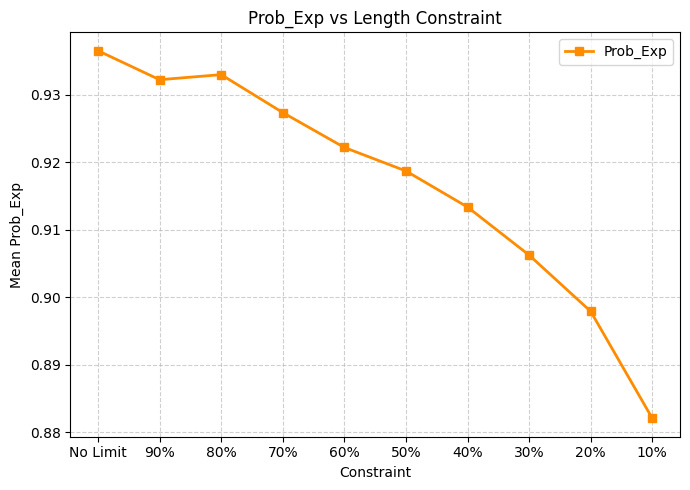

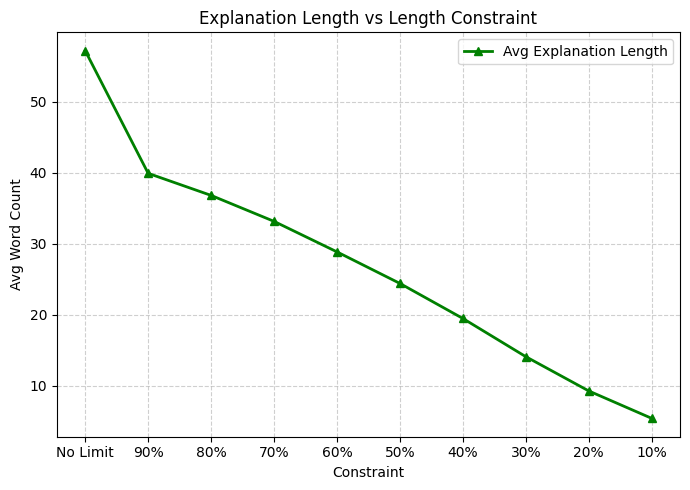

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ─────── Load All Eval CSVs ───────
file_paths = [
    "results_masked_0.csv",
    "results_masked_10.csv",
    "results_masked_20.csv",
    "results_masked_30.csv",
    "results_masked_40.csv",
    "results_masked_50.csv",
    "results_masked_60.csv",
    "results_masked_70.csv",
    "results_masked_80.csv",
    "results_masked_90.csv",
]

dfs = []
for file in file_paths:
    if os.path.exists(file):
        df = pd.read_csv(file)
        removed_pct = int(file.split("_")[-1].replace(".csv", ""))  # e.g. 20
        df["removed_percent"] = removed_pct

        # Compute explanation length
        if "masked_explanation" in df.columns:
            df["masked_exp_len"] = df["masked_explanation"].astype(str).apply(lambda x: len(x.split()))

        dfs.append(df)

eval_data = pd.concat(dfs, ignore_index=True)

# ─────── Aggregate ───────
metrics = eval_data.groupby("removed_percent").agg({
    "prob_exp": "mean",
    "masked_exp_len": "mean"
}).reset_index()

# ✅ CHANGED: Reverse order - start with highest constraint
order = [0, 90, 80, 70, 60, 50, 40, 30, 20, 10]
labels = ["No Limit", "90%", "80%", "70%", "60%", "50%", "40%", "30%", "20%", "10%"]
metrics = metrics.set_index("removed_percent").loc[order].reset_index()

print("\n📊 Summary per Constraint:")
print(metrics)

# ─────── Plot Prob_Exp ───────
plt.figure(figsize=(7,5))
plt.plot(labels, metrics["prob_exp"], marker="s", color="darkorange", linewidth=2, label="Prob_Exp")
plt.xlabel("Constraint")
plt.ylabel("Mean Prob_Exp")
plt.title("Prob_Exp vs Length Constraint")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ─────── Plot Explanation Length ───────
plt.figure(figsize=(7,5))
plt.plot(labels, metrics["masked_exp_len"], marker="^", color="green", linewidth=2, label="Avg Explanation Length")
plt.xlabel("Constraint")
plt.ylabel("Avg Word Count")
plt.title("Explanation Length vs Length Constraint")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()